## Dependencies
* sklearn 0.19
* matplotlib
* numpy
* pandas

## Import Library

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, tree, preprocessing, metrics
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
import sklearn.ensemble as ske

## Load and Play with Data

In [2]:
raw_df = pd.read_csv('./data/train.csv')
raw_df.columns = map(str.lower, raw_df.columns)
raw_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
grouping = pd.DataFrame({'count' : raw_df.groupby( [ 'pclass', 'survived'] ).size()}).reset_index()
bar = grouping.pivot(index='pclass', columns='survived', values='count')
grouping2 = pd.DataFrame({'count' : raw_df.groupby( [ 'sex', 'survived'] ).size()}).reset_index()
bar2 = grouping2.pivot(index='sex', columns='survived', values='count')
bar

survived,0,1
pclass,,
1,80,136
2,97,87
3,372,119


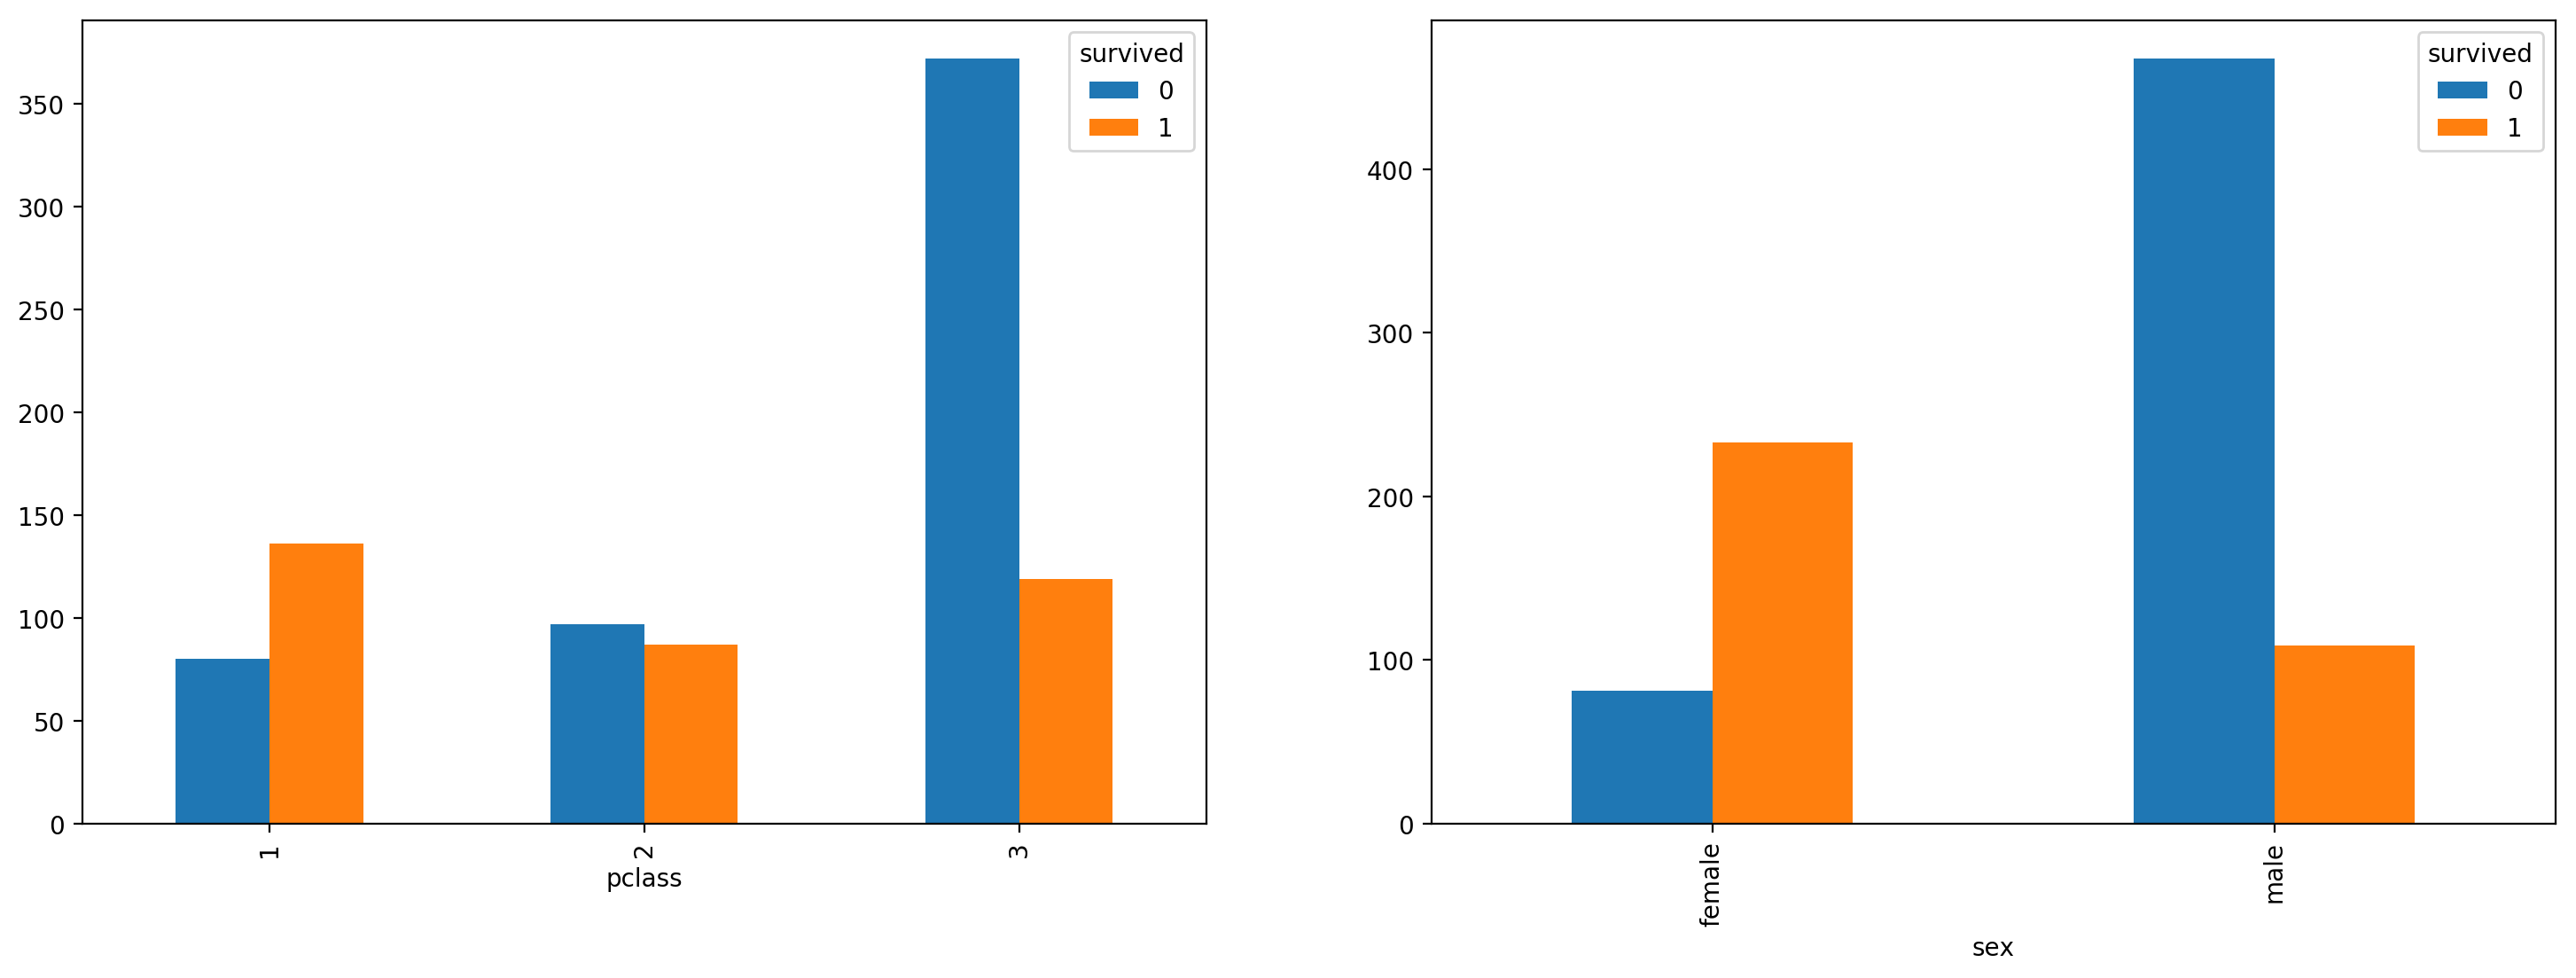

In [4]:
fig = plt.figure(figsize=(18,6), dpi=200) 

ax1 = plt.subplot2grid((1,2),(0,0))
bar.plot(kind='bar', ax=ax1)

ax2 = plt.subplot2grid((1,2),(0,1))
bar2.plot(kind='bar', ax=ax2)

## Preprocess Data

In [5]:
raw_df.count()

passengerid    891
survived       891
pclass         891
name           891
sex            891
age            714
sibsp          891
parch          891
ticket         891
fare           891
cabin          204
embarked       889
dtype: int64

###### A look on the dataset
there are total 12 features and 3 of them contain null value

In [15]:
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = processed_df.embarked.fillna('-')
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df["age"].fillna(processed_df["age"].mean(), inplace=True)
    
    processed_df = processed_df.drop(['fare','name','ticket', "cabin", "passengerid"],axis=1)
    return processed_df

In [19]:
processed_df = preprocess_titanic_df(raw_df)
processed_df.mean()

survived     0.383838
pclass       2.308642
sex          0.647587
age         29.699118
sibsp        0.523008
parch        0.381594
embarked     2.529742
dtype: float64

In [8]:
raw_test_df = pd.read_csv('./data/test.csv')
test_ans_df = pd.read_csv('./data/gender_submission.csv')
raw_test_df.columns = map(str.lower, raw_test_df.columns) 
test_ans_df.columns = map(str.lower, test_ans_df.columns) 
test_df = preprocess_titanic_df(raw_test_df)
test_df.count()

pclass      418
sex         418
age         332
sibsp       418
parch       418
fare        417
embarked    418
dtype: int64

## Split the data

In [9]:
features = processed_df.drop(['survived'], axis=1).values
label = processed_df['survived'].values
features_train, features_test, label_train, label_test = train_test_split(features,label,test_size=0.2)

## Decision Tree

In [10]:
clf_dt = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10)
clf_dt.fit(features, label)
clf_dt.score(features_test, label_test)
# pd.DataFrame(data=X_train)
# org = pd.DataFrame(data=y_train) 
# se = pd.Series(predicted)
# org['predicted'] = se.values
# org

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

#### Cross Validation 

In [ ]:
shuffle_validator = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_val_score(clf, features, label, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))
test_classifier(clf_dt)

#### Predictation

In [ ]:
expected = test_ans_df['survived'].values
predicted = clf_dt.predict(test_df.values)
metrics.classification_report(expected, predicted)

In [ ]:
metrics.confusion_matrix(expected, predicted)

## KNN

## Other simple Classification

The **“Random Forest”** classification algorithm will create a multitude of (generally very poor) trees for the data set using different random subsets of the input variables, and will return whichever prediction was returned by the most trees. This helps to avoid “overfitting”, a problem that occurs when a model is so tightly fitted to arbitrary correlations in the training data that it performs poorly on test data.

The **“Gradient Boosting”** classifier will generate many weak, shallow prediction trees and will combine, or “boost”, them into a strong model. This model performs very well on our data set, but has the drawback of being relatively slow and difficult to optimize, as the model construction happens sequentially so it cannot be parallelized.

A **“Voting”** classifier can be used to apply multiple conceptually divergent classification models to the same data set and will return the majority vote from all of the classifiers. For instance, if the gradient boosting classifier predicts that a passenger will not survive, but the decision tree and random forest classifiers predict that they will live, the voting classifier will chose the latter.


In [ ]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

In [ ]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

In [ ]:
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)